# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns array of hough lines.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines
    
def lines_img(img, lines):    
    """
    `img` is an image with desired shape
        
    Returns a blank image with lines drawn on it.
    """
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the lines_img(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape! TODO
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def draw_region_of_interest(img, vertices):
    
    #vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)

    color = [0,255,0]
    
    left_bottom = (vertices[0][0][0], vertices[0][0][1])
    left_top = (vertices[0][1][0], vertices[0][1][1])
    right_top = (vertices[0][2][0], vertices[0][2][1])
    right_bottom = (vertices[0][3][0], vertices[0][3][1])

    bottom_center = ((right_bottom[0]+left_bottom[0])//2, right_bottom[1])
    top_center = ((right_top[0]+left_top[0])//2, right_top[1])

    
    cv2.line(img, left_bottom, left_top, color, 2)
    cv2.line(img, left_top, right_top, color, 2)
    cv2.line(img, right_top, right_bottom, color, 2)
    cv2.line(img, right_bottom, left_bottom, color, 2)
    cv2.line(img, bottom_center, top_center, color, 2)

def line_coeffs(line):
    """
    from known end points (x0,y0), (x1,y1) of a line segment solve c0 and c1 for equation y = c0 + c1*x.
    line == [x0, y0, x1, y1]
    """
    c1 = (line[3]-line[1])/(line[2]-line[0]) # slope
    c0 = line[1] - c1 * line[0]
    return c0, c1

def line_length(line):
    """
    Return length of a line segment
    """
    a = np.square([line[2]-line[0]])[0]
    b = np.square([line[2]-line[0]])[0]
    
    return np.sqrt([a+b])[0]

def line_filter(new, prev, a):
    """
    Apply first order filter for new line
    `new` new line before smoothing
    `prev` previous drawn line
    `a` smoothing factor
    """
    if line_length(prev[0]) > 0.0:
        line = a*new + (1.0-a)*prev
    else:
        line = new

    return line.astype(np.int32)
    
def average_left_right(lines, center, bottom, top):
    """
    `lines` line segments from Hough transform
    `center` center of the region of interest (x-axis)
    `bottom` largest y-axis value where lines should reach
    `top` smallest y-axis value where lines should reach
    """

    right_lines = []
    right_lengths = []
    left_lines = []
    left_lengths = []

    for line in lines:
        c0, c1 = line_coeffs(line[0])
        len = line_length(line[0])
        if c1 > 0 and line[0][2] > center:
            right_lines.append((c0,c1))
            right_lengths.append(len)
            #print(c0, c1, len, line[0])
        elif c1 < 0 and line[0][2] < center:
            left_lines.append((c0,c1))
            left_lengths.append(len)
            
    ravg = np.average(right_lines, axis=0, weights=right_lengths)
    lavg = np.average(left_lines, axis=0, weights=left_lengths)
    
    # now calculate end points for left and right line segments
    left_line = np.array([[(bottom-lavg[0])/lavg[1],bottom,(top-lavg[0])/lavg[1],top]], dtype=np.int32)
    right_line = np.array([[(bottom-ravg[0])/ravg[1],bottom,(top-ravg[0])/ravg[1],top]], dtype=np.int32)

    return left_line, right_line

## Solution

The basic solution is below. `Parameters`-class instance encapsulates parameters for the processing pipeline. `find_lane_lines()` is the actual pipeline. To run the pipeline, set parameters in `process_image` function and invoke the pipeline. 

In [18]:
class Parameters:
    
    # global filtering parameters
    right_line = np.array([[0,0,0,0]], dtype=np.int32)
    left_line = np.array([[0,0,0,0]], dtype=np.int32)
    smoothing_factor = 1.0
    
    @staticmethod
    def reset_lines(a):
        """ Reset filtering parameters and set smoothing factor """
        Parameters.right_line = np.array([[0,0,0,0]], dtype=np.int32)
        Parameters.left_line = np.array([[0,0,0,0]], dtype=np.int32)
        Parameters.smoothing_factor = a
        
    
    def __init_(self):
        # Gaussian blur kernel size
        self.kernel_size = None  
        # Canny transform thresholds
        self.low_threshold = None 
        self.high_threshold = None
        # Region of interest
        self.left_bottom = None
        self.left_top = None
        self.right_bottom = None
        self.right_top = None
        # Hough transform parameters
        self.rho = None           # distance resolution in pixels of the Hough grid
        self.theta = None         # angular resolution in radians of the Hough grid
        self.threshold = None     # minimum number of votes (intersections in Hough grid cell)
        self.min_line_len = None  # minimum number of pixels making up a line
        self.max_line_gap = None  # maximum gap in pixels between connectable line segments
        # Other stuff
        self.do_averaging = None            # Run averaging for line segments
        self.show_region_of_interest = None # Show region of interest in final image
        

def find_lane_lines(img, p):
                    
    """
    Pipeline for finding left and right lane line from an image
    `img` is the original color image and return 
    `p` contains the processing parameters for the pipeline
    
    Return the original image with lane lines overlay.
    """    
    img_shape = img.shape

    gray = grayscale(img)
    
    # Bluring and Canny transform
    blur_gray = gaussian_blur(gray, p.kernel_size)
    edges = canny(blur_gray, p.low_threshold, p.high_threshold)
    
    # Mask the region of interest
    vertices = np.array([[p.left_bottom, p.left_top, p.right_top, p.right_bottom]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Get Hough lines
    lines = hough_lines(masked_edges, p.rho, p.theta, p.threshold, p.min_line_len, p.max_line_gap)
    if p.do_averaging:
        left_line, right_line = average_left_right(lines, (p.right_top[0]+p.left_top[0])/2, img_shape[0], p.left_top[1])
        # Apply filter in order to avoid line flickering during video
        # If smoothing factor is 1.0, no filtering is done
        left_line = line_filter(left_line, Parameters.left_line, Parameters.smoothing_factor)
        right_line = line_filter(right_line, Parameters.right_line, Parameters.smoothing_factor)
        
        # Add lines to the image
        line_image = lines_img(masked_edges, [left_line, right_line])
        
        #  Remember previous values
        Parameters.right_line = right_line
        Parameters.left_line = left_line       
    else:
        line_image = lines_img(masked_edges, lines) # show 'raw' hough lines  
    
    combined_image = weighted_img(line_image, img)
    
    if p.show_region_of_interest:
        draw_region_of_interest(combined_image, vertices)
    
    return combined_image


def process_image(img):
    
    p = Parameters()
    
    img_shape = img.shape
    p.left_bottom = (80, img_shape[0]-20)
    p.left_top = (420, 330)
    p.right_bottom = (img_shape[1], img_shape[0]-20)
    p.right_top = (560, 330)
    
    p.rho = 2
    p.theta = np.pi/180
    p.threshold = 25
    p.min_line_len = 10
    p.max_line_gap = 1
    
    p.kernel_size = 7
    p.low_threshold = 100
    p.high_threshold = 200

    p.do_averaging = True
    p.show_region_of_interest = False
    
    return find_lane_lines(img, p)

    

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [19]:
import os
image_files = os.listdir("test_images/")
print(image_files)
Parameters.reset_lines(1.0)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


run your solution on all test_images and make copies into the test_images directory).

solidWhiteCurve.jpg (540, 960, 3) :


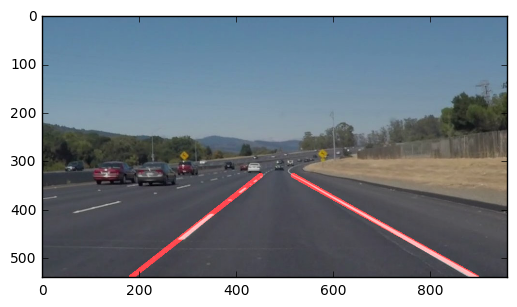

In [20]:
image = mpimg.imread("test_images/" + image_files[0])
result = process_image(image)
print(image_files[0], image.shape, ':')
plt.imshow(result);

solidWhiteRight.jpg :


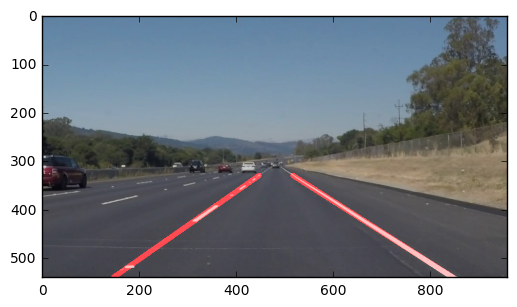

In [21]:
image = mpimg.imread("test_images/" + image_files[1])
result = process_image(image)
print(image_files[1], ':')
plt.imshow(result);

solidYellowCurve.jpg :


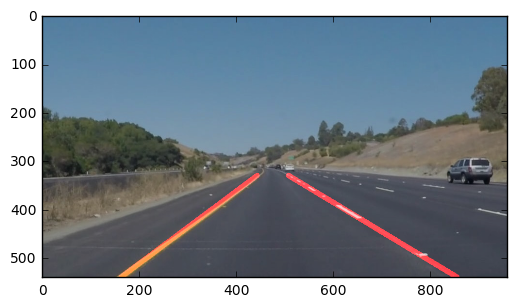

In [22]:
image = mpimg.imread("test_images/" + image_files[2])
result = process_image(image)
print(image_files[2], ':')
plt.imshow(result);

solidYellowCurve2.jpg :


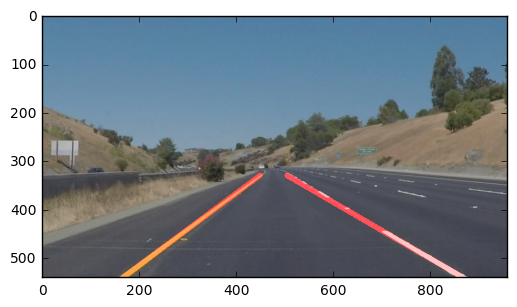

In [23]:
image = mpimg.imread("test_images/" + image_files[3])
result = process_image(image)
print(image_files[3], ':')
plt.imshow(result);

solidYellowLeft.jpg :


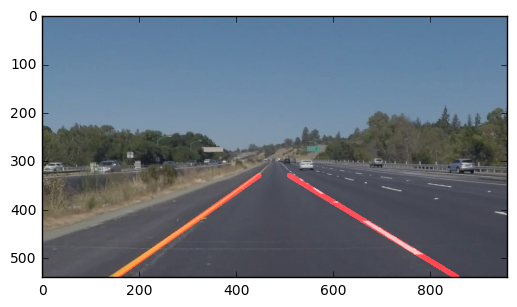

In [24]:
image = mpimg.imread("test_images/" + image_files[4])
result = process_image(image)
print(image_files[4], ':')
plt.imshow(result);

whiteCarLaneSwitch.jpg :


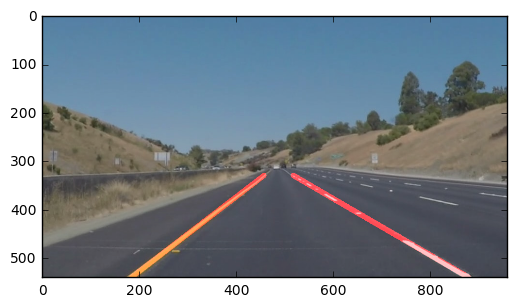

In [25]:
image = mpimg.imread("test_images/" + image_files[5])
result = process_image(image)
print(image_files[5], ':')
plt.imshow(result);

# Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [27]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
Parameters.reset_lines(0.5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 47.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.39 s, sys: 477 ms, total: 2.87 s
Wall time: 5.31 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [30]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
Parameters.reset_lines(0.25)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:16<00:00, 41.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 7.62 s, sys: 2.05 s, total: 9.67 s
Wall time: 17 s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Basically the pipeline is very similar as given in quizes. Averaging/extrapolation is done by finding the average line y=mx+b from left and right side, and drawing segment of those lines between the top of the region of interest and bottom of the image. 

The drawback of the method is, that calculated slopes from Hough lines seem to vary a lot. Especially when the line is non-solid, the resulting output flickers a lot in video. For mitigation, simple filtering of the output was implemented.

Better would be to provide better quality data for the pipeline. This may be achieved by adjusting parameters (Gaussian blur, Canny transform, Hough transform) and/or filtering out bad values (for example, segments with slopes that do not fit the neighbouring segments). Parameter adjustment would need more time for exploring, and better understanding of the methods.

Two major shortcomings of the pipeline are 1) applies only for relatively straight roads 2) cannot handle variation in road surface (challenge task!) 

1) Fitting Hough lines to a curve (polynomial fitting) could solve this.
2) Would require enhanced image processing. 

Challenge task is started but not finished. Looking forward to learn how to do that!

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
def process_challenge(img):
    
    p = Parameters()
    
    img_shape = img.shape # 720 x 1280
    p.left_bottom = (100, img_shape[0]-55)
    p.left_top = (img_shape[1]//2-50, 440)
    p.right_bottom = ( img_shape[1]-80,  img_shape[0]-55)
    p.right_top = (img_shape[1]//2+90, 440)
    
    p.kernel_size = 7
    p.low_threshold = 50
    p.high_threshold = 150
    
    p.rho = 2
    p.theta = np.pi/180
    p.threshold = 15
    p.min_line_len = 5
    p.max_line_gap = 1
    p.do_averaging = False # not yet
    p.show_region_of_interest = True # for testing
    
    return find_lane_lines(img, p)


challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_challenge)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:11<00:00, 21.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 4.84 s, sys: 1.24 s, total: 6.08 s
Wall time: 13 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))